In [14]:
import numpy as np 
import pandas as pd 
import os
import gc
import cv2
from PIL import Image
import random
import torch

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

#### Data extraction

In [15]:
# There are two folders named Bikes and Horse in the path_name
# this method reads the data from each category folder and splits the data for each category in train and test based on the train_ratio parameter.

def extract_data(path_name, categories, train_ratio=0.9):
    path = path_name
    data = []
    im_w = 224
    im_h = 224
    # categories = ['Bikes', 'Horses']
    for x in range(len(categories)):
        cat = categories[x]
        cat_data = []
        sub_path = os.path.join(path, cat)
        for filename in os.listdir(sub_path):
            img_path = os.path.join(sub_path, filename)
            imag = cv2.imread(img_path)
            img_from_ar = Image.fromarray(imag, 'RGB')
            resized_image = img_from_ar.resize((im_w, im_h))
            cat_data.append([np.array(resized_image), x])

        # Split data into train and test for this category
        split_index = int(len(cat_data) * train_ratio)
        random.shuffle(cat_data)
        train_data = cat_data[:split_index]
        test_data = cat_data[split_index:]
        data.extend(train_data)
        data.extend(test_data)
    random.shuffle(data)  # Shuffle the data
    return data

train_ratio = 0.9  # Adjust this ratio as desired
path_name = "./Assignment2_BikeHorses/"
categories = ['Bikes', 'Horses']

# path_name = "./Fish_Dataset/"
# categories = ['Black_Sea_Sprat', 'Gilt_Head_Bream', 'Hourse_Mackerel', 'Red_Mullet', 'Red_Sea_Bream', 'Sea_Bass', 'Shrimp', 'Striped_Red_Mullet', 'Trout']
data = extract_data(path_name, categories, train_ratio)

# Split data into train and test
split_index = int(len(data) * train_ratio)
train = data[:split_index]
test = data[split_index:]

#### Load the pretrained alexnet model and fix the parameters for each layer

In [16]:
from torchvision.models import alexnet
# Load the pretrained AlexNet model
net = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained = True)

for params in net.parameters():
    params.requires_grad=False
net.eval()

Using cache found in /home/ricky/.cache/torch/hub/pytorch_vision_v0.6.0
/home/ricky/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ricky/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [17]:
# Replace last layer of the pretrained network with new layer so that they can be finetuned to get better results.
# Add an extra linear layer from 1000 input to 2 out_features and then a softmax layer.

net.classifier[-1] = torch.nn.Linear(in_features=4096, out_features=1000, bias=True)
net = torch.nn.Sequential(net,torch.nn.Linear(in_features=1000,out_features=len(categories),bias=True),torch.nn.Softmax(dim=1))

In [18]:
# For transformation of training set do randomHorizontalFlip to make the model more genralized.
import torchvision.transforms as transforms

# Normalize training set together with augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

# Normalize test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

batch_size=16

In [19]:
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    def __init__(self,dataset):
        self.dataset = dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        return self.dataset[idx]

trainset = ImageDataset(train)
testset = ImageDataset(test)

In [20]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
def generate_batch(batch):
    images = [x[0] for x in batch]  # Extract images from the batch
    labels = [x[1] for x in batch]  # Extract labels from the batch
    
    # Convert images to tensors and apply transformations
    images = torch.stack([transform(x) for x in images])
    labels = torch.tensor(labels, dtype=torch.long)
    
    return images, labels


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2,collate_fn = generate_batch)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2,collate_fn = generate_batch)

In [21]:
import torch.optim as optim
import torch.nn as nn

# Using CrossEntropy loss as we are handling classification problem
# usig momentum method for optimization

optimizer = optim.SGD(net.parameters(),lr = 0.001,momentum = 0.9)      
criterion = nn.CrossEntropyLoss()           
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net.to(device)
criterion.to(device)

cpu


CrossEntropyLoss()

In [22]:
import matplotlib.pyplot as plt
train_losses = []
validation_losses = []
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)  # get the inputs; data is a list of [inputs, labels]
        optimizer.zero_grad()  # zero the parameter gradients
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    train_losses.append((running_loss*32)/len(trainloader))
    running_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images,labels = images.to(device),labels.to(device)
            outputs = net(images)
            loss = criterion(outputs,labels)
            running_loss += loss.item()
    validation_losses.append((running_loss*32)/len(testloader))
    print("{} Epoch done".format(epoch))

0 Epoch done
1 Epoch done
2 Epoch done
3 Epoch done
4 Epoch done
5 Epoch done
6 Epoch done
7 Epoch done
8 Epoch done
9 Epoch done
10 Epoch done
11 Epoch done
12 Epoch done
13 Epoch done
14 Epoch done
15 Epoch done
16 Epoch done
17 Epoch done
18 Epoch done
19 Epoch done
20 Epoch done
21 Epoch done
22 Epoch done
23 Epoch done
24 Epoch done


Finished Training


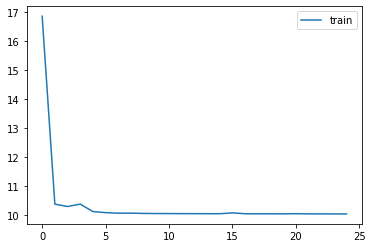

In [23]:
print('Finished Training')
plt.plot(train_losses,label = 'train')
plt.legend()

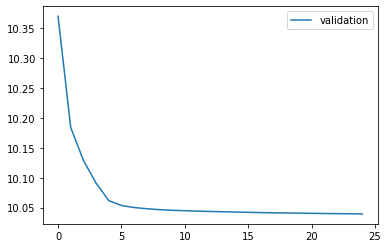

In [24]:
plt.plot(validation_losses,label = 'validation')
plt.legend()

## Store the fine tuned network.
This can and will be later used for extracting features and then various methods like support vector machine or linear regression can be applied on it to get different models for classification.

In [25]:
PATH = './alexnet_fine_tuned.pth'
torch.save(net.state_dict(), PATH)
temp_net = net

In [26]:
PATH = './alexnet_fine_tuned.pth'
# net = Net()
net.load_state_dict(torch.load(PATH))
temp_net = net

In [27]:
net = net[:-2]

In [28]:
def make_data(dataloader):
    train_features,train_labels = [],[]
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images,labels = images.to(device),labels.to(device)
            output = net(images)
            train_features.extend(output)
            train_labels.extend(labels)
    return train_features,train_labels

In [29]:
device1 = torch.device('cpu')

In [30]:
train_features,train_labels = make_data(trainloader)

In [31]:
test_features,test_labels = make_data(testloader)

In [32]:
training_data = [t.to(device1).numpy() for t in train_features]
labels = [t.to(device1).numpy() for t in train_labels]
testing_data = [t.to(device1).numpy() for t in train_features]
test_labels = [t.to(device1).numpy() for t in train_labels]

In [33]:
training_data,labels = pd.DataFrame(training_data),pd.DataFrame(labels)

In [34]:
testing_data,testing_labels = pd.DataFrame(testing_data),pd.DataFrame(test_labels)

In [35]:
training_data.to_csv('./training_data.csv',index=False)
labels.to_csv('./labels.csv',index=False)
testing_data.to_csv('./testing_data.csv',index=False)
testing_labels.to_csv('./test_labels.csv',index=False)

In [36]:
train = pd.concat([training_data,testing_data])
y = pd.concat([labels,testing_labels])

In [37]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(train,y,shuffle=True,random_state=2021,test_size=0.1)

In [38]:
print(y_test.shape)

(33, 1)


###  Applying support vector machine model on the extracted features

In [39]:
from sklearn.svm import SVC

svc = SVC(kernel='linear')
svc.fit(X_train,y_train)

/home/ricky/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(kernel='linear')

In [40]:
from sklearn.metrics import accuracy_score

y_pred = svc.predict(X_test)
print(accuracy_score(y_test,y_pred))

1.0


#### Applying logistic regression on the extracted features for classification

In [41]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter = 1000,l1_ratio=0)
lr.fit(X_train,y_train)

/home/ricky/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/ricky/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(l1_ratio=0, max_iter=1000)

In [42]:
from sklearn.metrics import accuracy_score

y_pred = lr.predict(X_test)
print(accuracy_score(y_test,y_pred))

1.0


#### Applying KNN clustering on the extracted features for classification

In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


/home/ricky/.local/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 1.0
